# Introduction

This notebook imports the csv file that was output from notebook 2.

**NOTE: Version 0.11.0 of seaborn is required to run certain plots in this file, so use the code in the third cell in case certain plots are not working (seaborn changed the name of some of their plot functions between the old and new versions)**

A dataframe that consists of only countries in the region of Africa is created.

The dataframe is cleaned for modeling including the following:
 * Rows with null values are removed (this is where no protest occurred, but we think the row was included for time series analyis).
 * The null values in **participants_category** column are imputed based on the **participants** column
 
 * Drop columns that are text - such as **sources**, and also drop the demand/response columns except for the demand column that has all possible combinations of demands (**protesterdemand**), and the columns that each cover whether a given demand occurred for that data frame (such as **accomodations**) 
 
 * Three columns are one-hot encoded since they are categories: **country**,**participants_category**, **protesterdemand**

This dataframe is then used for modeling.  Modeling includes the following:

 * 7 model types were run for each of three cases, as described further below:
   * Logistic Regression
   * K-Nearest Neighbors
   * Decision Tree (**NOTE: only included in out-of-the-box models**)
   * Bagging
   * RandomForest
   * AdaBoost
   * SVC

 * Binary classification with accomodations as the target
   * the 7 model types are run out-of-the-box
   * the 6 model types are run using grid-search models with PCA
   * the 6 model types are run using grid-search models without PCA
   
   * **Random Forest Classifier with PCA gives the best results** although these are barely above the baseline performance
      * baseline score is: 87.6%
      * cv-score is: 88.8
      * train accuracy is: 88.9%
      * test accuracy is: 89.1%
   
 * Binary classification with whether state violence occurred as the target
   * the 7 model types are run out-of-the-box
   * the 6 model types are run using grid-search models without PCA
   * the 6 model types are run using grid-search models with PCA

   * **AdaBoost with PCA gives the best results** although these are barely above the baseline performance  
      * baseline score is: 87.1%
      * cv-score is: 88.7%
      * train accuracy is: 88.9%
      * test accuracy is: 88.8%

In [7]:
# run to update seaborn so that the new seaborn will work

# pip install seaborn==0.11.0

In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import classification as cl

pd.set_option('display.max_columns',None)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier 
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [9]:
df = pd.read_csv('../data/df_all.csv')

In [10]:
df.columns

Index(['id', 'country', 'ccode', 'year', 'region', 'protest', 'protestnumber',
       'startday', 'startmonth', 'startyear', 'endday', 'endmonth', 'endyear',
       'protesterviolence', 'location', 'participants_category',
       'participants', 'protesteridentity', 'protesterdemand1',
       'protesterdemand2', 'protesterdemand3', 'protesterdemand4',
       'stateresponse1', 'stateresponse2', 'stateresponse3', 'stateresponse4',
       'stateresponse5', 'stateresponse6', 'stateresponse7', 'sources',
       'notes', 'years', 'months', 'days', 'total_days',
       'dem_protesterdemand1', 'dem_protesterdemand2', 'dem_protesterdemand3',
       'dem_protesterdemand4', 'resp_stateresponse1', 'resp_stateresponse2',
       'resp_stateresponse3', 'resp_stateresponse4', 'resp_stateresponse5',
       'resp_stateresponse6', 'resp_stateresponse7', 'labor wage dispute',
       'land farm issue', 'police brutality', 'political behavior, process',
       'price increases, tax policy', 'removal of poli

In [11]:
africa_df = df[df['region'] == 'Africa'].copy()

In [12]:
list_of_countries = list(africa_df['country'].unique())

list_of_demands = ['labor wage dispute',
                   'land farm issue',
                   'police brutality',
                   'political behavior, process',
                   'price increases, tax policy',
                   'removal of politician',
                   'social restrictions']

list_of_responses = ['accomodation',
                     'arrests',
                     'beatings',
                     'crowd dispersal',
                     'ignore',
                     'killings',
                     'shootings']

# Clean Dataframe for modeling

In [13]:
africa_df.head()

,id,country,ccode,year,region,protest,protestnumber,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,location,participants_category,participants,protesteridentity,protesterdemand1,protesterdemand2,protesterdemand3,protesterdemand4,stateresponse1,stateresponse2,stateresponse3,stateresponse4,stateresponse5,stateresponse6,stateresponse7,sources,notes,years,months,days,total_days,dem_protesterdemand1,dem_protesterdemand2,dem_protesterdemand3,dem_protesterdemand4,resp_stateresponse1,resp_stateresponse2,resp_stateresponse3,resp_stateresponse4,resp_stateresponse5,resp_stateresponse6,resp_stateresponse7,labor wage dispute,land farm issue,police brutality,"political behavior, process","price increases, tax policy",removal of politician,social restrictions,accomodation,arrests,beatings,crowd dispersal,ignore,killings,shootings,state_violence,protesterdemand,stateresponse,protesterdemand_int,protesterdemand_str,stateresponse_int,stateresponse_str
7974,4021990000,Cape Verde,402,1990,Africa,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,NaN,999,999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0
7975,4021991000,Cape Verde,402,1991,Africa,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,NaN,999,999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0
7976,4021992000,Cape Verde,402,1992,Africa,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,NaN,999,999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0
7977,4021993000,Cape Verde,402,1993,Africa,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,NaN,999,999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0
7978,4021994000,Cape Verde,402,1994,Africa,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,NaN,999,999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0


In [17]:
africa_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3630 entries, 7974 to 11603
Data columns (total 67 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           3630 non-null   int64  
 1   country                      3630 non-null   object 
 2   ccode                        3630 non-null   int64  
 3   year                         3630 non-null   int64  
 4   region                       3630 non-null   object 
 5   protest                      3630 non-null   int64  
 6   protestnumber                3630 non-null   int64  
 7   startday                     3630 non-null   float64
 8   startmonth                   3630 non-null   float64
 9   startyear                    3630 non-null   float64
 10  endday                       3630 non-null   float64
 11  endmonth                     3630 non-null   float64
 12  endyear                      3630 non-null   float64
 13  protesterviole

## Address null values

In [18]:
# drops rows where no protest occurs (i.e. startday column is null)
africa_df_protests = africa_df[africa_df['startday'].notna()].copy()

In [19]:
africa_df_protests.isnull().sum()[africa_df_protests.isnull().sum() != 0]

location                 587
protesteridentity        587
sources                  589
notes                    587
dem_protesterdemand1    3630
dem_protesterdemand2    3630
dem_protesterdemand3    3630
dem_protesterdemand4    3630
resp_stateresponse1     3630
resp_stateresponse2     3630
resp_stateresponse3     3630
resp_stateresponse4     3630
resp_stateresponse5     3630
resp_stateresponse6     3630
resp_stateresponse7     3630
dtype: int64

## Analyze remaining columns with nulls

In [20]:
part_cats = africa_df_protests[['participants_category','participants','sources']].copy()

part_cats[part_cats['participants_category'].isnull()]

,participants_category,participants,sources


In [21]:
part_cats[part_cats['participants'].isnull()]

,participants_category,participants,sources


In [22]:
part_cats[part_cats['sources'].isnull()]

,participants_category,participants,sources
7974,999,999,NaN
7975,999,999,NaN
7976,999,999,NaN
7977,999,999,NaN
7978,999,999,NaN
...,...,...,...
11598,999,999,NaN
11600,999,999,NaN
11601,999,999,NaN
11602,999,999,NaN


### Based on above:

* The **participants_category** is more helpful, so where missing values occur - these could be imputed based on the **participants**

* The **participants** column can be dropped for modeling

* The **sources** column is more for reference and can be dropped for modelling

In [23]:
part_cats[part_cats['participants_category'].isnull()]

,participants_category,participants,sources


In [24]:
# input options

list(part_cats['participants_category'].unique())

['999', '100-999', '2000-4999', '5000-10000', '50-99', '>10000', '1000-1999']

In [25]:
africa_df_protests_clean = africa_df_protests.copy()

In [26]:
nums_to_50 = [8670, 8826, 9387, 9397, 9406, 9700, 9701]
nums_to_100 = [8320, 9698, 9704, 9742]
nums_to_1000 = [9539]  # CONSIDER REVIEWING THIS - COULD BE MORE
nums_to_2000 = [9395]
nums_to_10000 = [9167]

#Update values

for location in nums_to_50:
    africa_df_protests_clean['participants_category'].loc[location] = '50-99' 

for location in nums_to_100:
    africa_df_protests_clean['participants_category'].loc[location] = '100-999' 
    
for location in nums_to_1000:
    africa_df_protests_clean['participants_category'].loc[location] = '1000-1999' 
    
for location in nums_to_2000:
    africa_df_protests_clean['participants_category'].loc[location] = '2000-4999' 
    
for location in nums_to_10000:
    africa_df_protests_clean['participants_category'].loc[location] = '>10000' 

/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [27]:
# verify which columns that remain have nulls 
africa_df_protests_clean.isnull().sum()[africa_df_protests_clean.isnull().sum() != 0]

location                 587
protesteridentity        587
sources                  589
notes                    587
dem_protesterdemand1    3630
dem_protesterdemand2    3630
dem_protesterdemand3    3630
dem_protesterdemand4    3630
resp_stateresponse1     3630
resp_stateresponse2     3630
resp_stateresponse3     3630
resp_stateresponse4     3630
resp_stateresponse5     3630
resp_stateresponse6     3630
resp_stateresponse7     3630
dtype: int64

### as noted above - will be dropping columns participants and sources

## Determine which columns to keep

In [28]:
africa_df_protests_clean.head(3)

,id,country,ccode,year,region,protest,protestnumber,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,location,participants_category,participants,protesteridentity,protesterdemand1,protesterdemand2,protesterdemand3,protesterdemand4,stateresponse1,stateresponse2,stateresponse3,stateresponse4,stateresponse5,stateresponse6,stateresponse7,sources,notes,years,months,days,total_days,dem_protesterdemand1,dem_protesterdemand2,dem_protesterdemand3,dem_protesterdemand4,resp_stateresponse1,resp_stateresponse2,resp_stateresponse3,resp_stateresponse4,resp_stateresponse5,resp_stateresponse6,resp_stateresponse7,labor wage dispute,land farm issue,police brutality,"political behavior, process","price increases, tax policy",removal of politician,social restrictions,accomodation,arrests,beatings,crowd dispersal,ignore,killings,shootings,state_violence,protesterdemand,stateresponse,protesterdemand_int,protesterdemand_str,stateresponse_int,stateresponse_str
7974,4021990000,Cape Verde,402,1990,Africa,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,NaN,999,999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0
7975,4021991000,Cape Verde,402,1991,Africa,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,NaN,999,999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0
7976,4021992000,Cape Verde,402,1992,Africa,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,NaN,999,999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0,0,0


In [29]:
africa_df_protests_clean.columns

Index(['id', 'country', 'ccode', 'year', 'region', 'protest', 'protestnumber',
       'startday', 'startmonth', 'startyear', 'endday', 'endmonth', 'endyear',
       'protesterviolence', 'location', 'participants_category',
       'participants', 'protesteridentity', 'protesterdemand1',
       'protesterdemand2', 'protesterdemand3', 'protesterdemand4',
       'stateresponse1', 'stateresponse2', 'stateresponse3', 'stateresponse4',
       'stateresponse5', 'stateresponse6', 'stateresponse7', 'sources',
       'notes', 'years', 'months', 'days', 'total_days',
       'dem_protesterdemand1', 'dem_protesterdemand2', 'dem_protesterdemand3',
       'dem_protesterdemand4', 'resp_stateresponse1', 'resp_stateresponse2',
       'resp_stateresponse3', 'resp_stateresponse4', 'resp_stateresponse5',
       'resp_stateresponse6', 'resp_stateresponse7', 'labor wage dispute',
       'land farm issue', 'police brutality', 'political behavior, process',
       'price increases, tax policy', 'removal of poli

In [32]:
columns_to_drop = ['ccode','region','location','participants','protesteridentity', 
                   'protesterdemand1','protesterdemand2', 'protesterdemand3', 'protesterdemand4',
                   'dem_protesterdemand1','dem_protesterdemand2', 
                   'dem_protesterdemand3', 'dem_protesterdemand4',
                   'stateresponse1', 'stateresponse2', 'stateresponse3', 'stateresponse4',
                   'stateresponse5', 'stateresponse6', 'stateresponse7', 
                   'resp_stateresponse1', 'resp_stateresponse2', 'resp_stateresponse3', 
                   'resp_stateresponse4','resp_stateresponse5', 'resp_stateresponse6', 'resp_stateresponse7',
                   'sources','notes', 
                   'protesterdemand_int', 'protesterdemand_str',
                   'stateresponse_int', 'stateresponse_str'
                   ]

africa_df_protests_clean_cols = africa_df_protests_clean.drop(columns = columns_to_drop).copy()
africa_df_protests_clean_cols.head()

,id,country,year,protest,protestnumber,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,participants_category,years,months,days,total_days,labor wage dispute,land farm issue,police brutality,"political behavior, process","price increases, tax policy",removal of politician,social restrictions,accomodation,arrests,beatings,crowd dispersal,ignore,killings,shootings,state_violence,protesterdemand,stateresponse
7974,4021990000,Cape Verde,1990,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0
7975,4021991000,Cape Verde,1991,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0
7976,4021992000,Cape Verde,1992,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0
7977,4021993000,Cape Verde,1993,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0
7978,4021994000,Cape Verde,1994,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,999,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0.0,0.0,0.0


## Determine which columns to one-hot encode

In [33]:
cats_to_encode = ['country','participants_category','protesterdemand']

In [34]:
all_encoded = pd.get_dummies(africa_df_protests_clean_cols, columns = cats_to_encode, drop_first = True)

## Do last checks before model

In [35]:
all_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3630 entries, 7974 to 11603
Columns: 123 entries, id to protesterdemand_1100011.0
dtypes: float64(17), int64(14), uint8(92)
memory usage: 1.2 MB


In [36]:
all_encoded.describe()

,id,year,protest,protestnumber,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,years,months,days,total_days,labor wage dispute,land farm issue,police brutality,"political behavior, process","price increases, tax policy",removal of politician,social restrictions,accomodation,arrests,beatings,crowd dispersal,ignore,killings,shootings,state_violence,stateresponse,country_Benin,country_Botswana,country_Burkina Faso,country_Burundi,country_Cameroon,country_Cape Verde,country_Central African Republic,country_Chad,country_Comoros,country_Congo Brazzaville,country_Congo Kinshasa,country_Djibouti,country_Equatorial Guinea,country_Eritrea,country_Ethiopia,country_Gabon,country_Gambia,country_Ghana,country_Guinea,country_Guinea-Bissau,country_Ivory Coast,country_Kenya,country_Lesotho,country_Liberia,country_Madagascar,country_Malawi,country_Mali,country_Mauritania,country_Mauritius,country_Mozambique,country_Namibia,country_Niger,country_Nigeria,country_Rwanda,country_Senegal,country_Sierra Leone,country_Somalia,country_South Africa,country_South Sudan,country_Swaziland,country_Tanzania,country_Togo,country_Uganda,country_Zambia,country_Zimbabwe,participants_category_1000-1999,participants_category_2000-4999,participants_category_50-99,participants_category_5000-10000,participants_category_999,participants_category_>10000,protesterdemand_1.0,protesterdemand_10.0,protesterdemand_11.0,protesterdemand_100.0,protesterdemand_101.0,protesterdemand_110.0,protesterdemand_111.0,protesterdemand_1000.0,protesterdemand_1001.0,protesterdemand_1010.0,protesterdemand_1011.0,protesterdemand_1100.0,protesterdemand_1101.0,protesterdemand_2000.0,protesterdemand_10000.0,protesterdemand_10001.0,protesterdemand_10010.0,protesterdemand_10100.0,protesterdemand_11000.0,protesterdemand_11001.0,protesterdemand_100000.0,protesterdemand_100001.0,protesterdemand_100010.0,protesterdemand_100100.0,protesterdemand_100101.0,protesterdemand_101000.0,protesterdemand_101001.0,protesterdemand_110000.0,protesterdemand_110001.0,protesterdemand_110011.0,protesterdemand_111000.0,protesterdemand_1000000.0,protesterdemand_1000001.0,protesterdemand_1000011.0,protesterdemand_1000100.0,protesterdemand_1001001.0,protesterdemand_1010000.0,protesterdemand_1010001.0,protesterdemand_1100000.0,protesterdemand_1100001.0,protesterdemand_1100011.0
count,3.630000e+03,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3.630000e+03,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.00000,3630.000000,3630.000000,3630.000000,3630.000000,3630.00000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000
mean,5.020552e+09,2006.076309,0.838292,7.411570,174.796694,166.694766,1843.487879,174.867218,166.700000,1843.488705,161.859780,0.000826,0.005234,0.070523,0.531818,0.137190

In [37]:
all_encoded.describe()

,id,year,protest,protestnumber,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,years,months,days,total_days,labor wage dispute,land farm issue,police brutality,"political behavior, process","price increases, tax policy",removal of politician,social restrictions,accomodation,arrests,beatings,crowd dispersal,ignore,killings,shootings,state_violence,stateresponse,country_Benin,country_Botswana,country_Burkina Faso,country_Burundi,country_Cameroon,country_Cape Verde,country_Central African Republic,country_Chad,country_Comoros,country_Congo Brazzaville,country_Congo Kinshasa,country_Djibouti,country_Equatorial Guinea,country_Eritrea,country_Ethiopia,country_Gabon,country_Gambia,country_Ghana,country_Guinea,country_Guinea-Bissau,country_Ivory Coast,country_Kenya,country_Lesotho,country_Liberia,country_Madagascar,country_Malawi,country_Mali,country_Mauritania,country_Mauritius,country_Mozambique,country_Namibia,country_Niger,country_Nigeria,country_Rwanda,country_Senegal,country_Sierra Leone,country_Somalia,country_South Africa,country_South Sudan,country_Swaziland,country_Tanzania,country_Togo,country_Uganda,country_Zambia,country_Zimbabwe,participants_category_1000-1999,participants_category_2000-4999,participants_category_50-99,participants_category_5000-10000,participants_category_999,participants_category_>10000,protesterdemand_1.0,protesterdemand_10.0,protesterdemand_11.0,protesterdemand_100.0,protesterdemand_101.0,protesterdemand_110.0,protesterdemand_111.0,protesterdemand_1000.0,protesterdemand_1001.0,protesterdemand_1010.0,protesterdemand_1011.0,protesterdemand_1100.0,protesterdemand_1101.0,protesterdemand_2000.0,protesterdemand_10000.0,protesterdemand_10001.0,protesterdemand_10010.0,protesterdemand_10100.0,protesterdemand_11000.0,protesterdemand_11001.0,protesterdemand_100000.0,protesterdemand_100001.0,protesterdemand_100010.0,protesterdemand_100100.0,protesterdemand_100101.0,protesterdemand_101000.0,protesterdemand_101001.0,protesterdemand_110000.0,protesterdemand_110001.0,protesterdemand_110011.0,protesterdemand_111000.0,protesterdemand_1000000.0,protesterdemand_1000001.0,protesterdemand_1000011.0,protesterdemand_1000100.0,protesterdemand_1001001.0,protesterdemand_1010000.0,protesterdemand_1010001.0,protesterdemand_1100000.0,protesterdemand_1100001.0,protesterdemand_1100011.0
count,3.630000e+03,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3.630000e+03,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.00000,3630.000000,3630.000000,3630.000000,3630.000000,3630.00000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000,3630.000000
mean,5.020552e+09,2006.076309,0.838292,7.411570,174.796694,166.694766,1843.487879,174.867218,166.700000,1843.488705,161.859780,0.000826,0.005234,0.070523,0.531818,0.137190

In [38]:
all_encoded.isnull().sum()[all_encoded.isnull().sum() != 0]

Series([], dtype: int64)

# Binary classification - target is accommodations

### note that one row has accommodation = 2 - this row appears once and unclear if data entered correctly. - so oing to drop (likely it should just be 1, but it won't make a difference)

In [39]:
all_encoded[all_encoded['accomodation'] == 2]

,id,year,protest,protestnumber,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,years,months,days,total_days,labor wage dispute,land farm issue,police brutality,"political behavior, process","price increases, tax policy",removal of politician,social restrictions,accomodation,arrests,beatings,crowd dispersal,ignore,killings,shootings,state_violence,stateresponse,country_Benin,country_Botswana,country_Burkina Faso,country_Burundi,country_Cameroon,country_Cape Verde,country_Central African Republic,country_Chad,country_Comoros,country_Congo Brazzaville,country_Congo Kinshasa,country_Djibouti,country_Equatorial Guinea,country_Eritrea,country_Ethiopia,country_Gabon,country_Gambia,country_Ghana,country_Guinea,country_Guinea-Bissau,country_Ivory Coast,country_Kenya,country_Lesotho,country_Liberia,country_Madagascar,country_Malawi,country_Mali,country_Mauritania,country_Mauritius,country_Mozambique,country_Namibia,country_Niger,country_Nigeria,country_Rwanda,country_Senegal,country_Sierra Leone,country_Somalia,country_South Africa,country_South Sudan,country_Swaziland,country_Tanzania,country_Togo,country_Uganda,country_Zambia,country_Zimbabwe,participants_category_1000-1999,participants_category_2000-4999,participants_category_50-99,participants_category_5000-10000,participants_category_999,participants_category_>10000,protesterdemand_1.0,protesterdemand_10.0,protesterdemand_11.0,protesterdemand_100.0,protesterdemand_101.0,protesterdemand_110.0,protesterdemand_111.0,protesterdemand_1000.0,protesterdemand_1001.0,protesterdemand_1010.0,protesterdemand_1011.0,protesterdemand_1100.0,protesterdemand_1101.0,protesterdemand_2000.0,protesterdemand_10000.0,protesterdemand_10001.0,protesterdemand_10010.0,protesterdemand_10100.0,protesterdemand_11000.0,protesterdemand_11001.0,protesterdemand_100000.0,protesterdemand_100001.0,protesterdemand_100010.0,protesterdemand_100100.0,protesterdemand_100101.0,protesterdemand_101000.0,protesterdemand_101001.0,protesterdemand_110000.0,protesterdemand_110001.0,protesterdemand_110011.0,protesterdemand_111000.0,protesterdemand_1000000.0,protesterdemand_1000001.0,protesterdemand_1000011.0,protesterdemand_1000100.0,protesterdemand_1001001.0,protesterdemand_1010000.0,protesterdemand_1010001.0,protesterdemand_1100000.0,protesterdemand_1100001.0,protesterdemand_1100011.0
11037,5652010003,2010,1,3,12.0,7.0,2010.0,1.0,8.0,2010.0,1.0,0.0,1.0,-11.0,19.5,1,0,0,1,0,0,0.0,2,0,0,1.0,1.0,0,0.0,0.0,1012.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
africa_df_protests_clean.loc[11037];

In [41]:
all_encoded = all_encoded.drop(11037, axis = 0).copy()

### Create X, y dataframes

In [42]:
columns_to_drop = list_of_responses + ['stateresponse','state_violence']
columns_of_interests = 'accomodation'

X = all_encoded.drop(columns = columns_to_drop)
y = all_encoded[columns_of_interests]

X.head()

,id,year,protest,protestnumber,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,years,months,days,total_days,labor wage dispute,land farm issue,police brutality,"political behavior, process","price increases, tax policy",removal of politician,social restrictions,country_Benin,country_Botswana,country_Burkina Faso,country_Burundi,country_Cameroon,country_Cape Verde,country_Central African Republic,country_Chad,country_Comoros,country_Congo Brazzaville,country_Congo Kinshasa,country_Djibouti,country_Equatorial Guinea,country_Eritrea,country_Ethiopia,country_Gabon,country_Gambia,country_Ghana,country_Guinea,country_Guinea-Bissau,country_Ivory Coast,country_Kenya,country_Lesotho,country_Liberia,country_Madagascar,country_Malawi,country_Mali,country_Mauritania,country_Mauritius,country_Mozambique,country_Namibia,country_Niger,country_Nigeria,country_Rwanda,country_Senegal,country_Sierra Leone,country_Somalia,country_South Africa,country_South Sudan,country_Swaziland,country_Tanzania,country_Togo,country_Uganda,country_Zambia,country_Zimbabwe,participants_category_1000-1999,participants_category_2000-4999,participants_category_50-99,participants_category_5000-10000,participants_category_999,participants_category_>10000,protesterdemand_1.0,protesterdemand_10.0,protesterdemand_11.0,protesterdemand_100.0,protesterdemand_101.0,protesterdemand_110.0,protesterdemand_111.0,protesterdemand_1000.0,protesterdemand_1001.0,protesterdemand_1010.0,protesterdemand_1011.0,protesterdemand_1100.0,protesterdemand_1101.0,protesterdemand_2000.0,protesterdemand_10000.0,protesterdemand_10001.0,protesterdemand_10010.0,protesterdemand_10100.0,protesterdemand_11000.0,protesterdemand_11001.0,protesterdemand_100000.0,protesterdemand_100001.0,protesterdemand_100010.0,protesterdemand_100100.0,protesterdemand_100101.0,protesterdemand_101000.0,protesterdemand_101001.0,protesterdemand_110000.0,protesterdemand_110001.0,protesterdemand_110011.0,protesterdemand_111000.0,protesterdemand_1000000.0,protesterdemand_1000001.0,protesterdemand_1000011.0,protesterdemand_1000100.0,protesterdemand_1001001.0,protesterdemand_1010000.0,protesterdemand_1010001.0,protesterdemand_1100000.0,protesterdemand_1100001.0,protesterdemand_1100011.0
7974,4021990000,1990,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7975,4021991000,1991,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7976,4021992000,1992,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7977,4021993000,1993,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7978,4021994000,1994,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
y.head()

7974    0
7975    0
7976    0
7977    0
7978    0
Name: accomodation, dtype: int64

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

## Baseline Scores

In [49]:
y.value_counts()

0    3247
1     382
Name: accomodation, dtype: int64

In [50]:
round(y.value_counts(normalize=True),3)

0    0.895
1    0.105
Name: accomodation, dtype: float64

### double check baselines for y_train and y_test

In [51]:
round(y_train.value_counts(normalize = True), 3)

0    0.895
1    0.105
Name: accomodation, dtype: float64

In [52]:
round(y_test.value_counts(normalize = True), 3)

0    0.894
1    0.106
Name: accomodation, dtype: float64

In [53]:
y_test.value_counts()

0    812
1     96
Name: accomodation, dtype: int64

## Scale Data

In [54]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

## Run out-of-the-box models on the data

In [55]:
log = LogisticRegression()
knn_c = KNeighborsClassifier()
dec_c = DecisionTreeClassifier()
bag_c = BaggingClassifier()
ran_c = RandomForestClassifier()
ada_c = AdaBoostClassifier()
svc = SVC()

models_c = [log, knn_c, dec_c, bag_c, ran_c, ada_c, svc]

def eval_models(list_of_models, X_train_sc,y_train, X_test_sc, y_test):
    for model in models_c:
        model.fit(X_train_sc, y_train)

        # Review Accuracy
        train_acc_score = model.score(X_train_sc, y_train)
        test_acc_score = model.score(X_test_sc, y_test)    
        print(f'For model {model}:')
        print(f'     Train Acc score: {train_acc_score.round(4)}\n     Test Acc score: {test_acc_score.round(4)}')


        # Create prediction to get f1_score
        train_pred = model.predict(X_train_sc)
        test_pred = model.predict(X_test_sc)

        train_f1 =f1_score(y_train, train_pred, average='binary')
        test_f1 = f1_score(y_test, test_pred, average='binary')

        print(f'     Train f1 score: {train_f1.round(3)}\n     Test f1 score: {test_f1.round(3)}\n\n')

In [56]:
eval_models(models_c, X_train_sc,y_train, X_test_sc, y_test)

For model LogisticRegression():
     Train Acc score: 0.9059
     Test Acc score: 0.902
     Train f1 score: 0.256
     Test f1 score: 0.252


For model KNeighborsClassifier():
     Train Acc score: 0.9166
     Test Acc score: 0.8866
     Train f1 score: 0.428
     Test f1 score: 0.226


For model DecisionTreeClassifier():
     Train Acc score: 1.0
     Test Acc score: 0.8469
     Train f1 score: 1.0
     Test f1 score: 0.347


For model BaggingClassifier():
     Train Acc score: 0.9849
     Test Acc score: 0.8932
     Train f1 score: 0.923
     Test f1 score: 0.312


For model RandomForestClassifier():
     Train Acc score: 1.0
     Test Acc score: 0.8998
     Train f1 score: 1.0
     Test f1 score: 0.26


For model AdaBoostClassifier():
     Train Acc score: 0.9044
     Test Acc score: 0.8866
     Train f1 score: 0.286
     Test f1 score: 0.214


For model SVC():
     Train Acc score: 0.9089
     Test Acc score: 0.902
     Train f1 score: 0.244
     Test f1 score: 0.198




In [57]:
# Function to review results

def results(fxn_name,X_test,y_test, X_train, y_train):

    #calculate cross-val score
    cvs = fxn_name.best_score_
    print('Best Score(cross_val_score) is: ', cvs)
    print('----------------------------------------------------------------------')
    
    # best params for the score
    bps = fxn_name.best_params_
    print('Best parameters for the best score(cross_val_score) are: ', bps)
    print('----------------------------------------------------------------------')
    
    # accuracy scores
    train_sc = fxn_name.score(X_train, y_train) 
    test_sc = fxn_name.score(X_test, y_test)
    print('Train score is: ', train_sc)
    print('Test score is: ', test_sc)
    print('----------------------------------------------------------------------')
    
    #Review predictions
    preds = fxn_name.predict(X_test)

    # Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

    plot_confusion_matrix(fxn_name, X_test, y_test, cmap='Blues', values_format='d');

    # Calculate the specificity and sensitivity
    spec = tn / (tn + fp)
    print('Specificity: ', spec)
    
    sens = tp / (tp + fn)
    print('Sensitivity: ', sens)

## Try pipelines with PCA and grid search (note scaling was done above)

In [58]:
pipe_log = Pipeline([
    ('pc',PCA()),
    ('model',LogisticRegression())
])

log_params = {'pc__n_components':[10,15,20],
              'model__max_iter': [500, 1000],
              'model__C': [.1, 1, 10, 100],
              'model__solver': ['liblinear', 'lbfgs', 'sag'],
              'model__penalty': ['l2']}

log = GridSearchCV(pipe_log,
                     log_params,
                     cv=5,
                     verbose=1)

log.fit(X_train_sc,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:   40.1s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pc', PCA()),
                                       ('model', LogisticRegression())]),
             param_grid={'model__C': [0.1, 1, 10, 100],
                         'model__max_iter': [500, 1000],
                         'model__penalty': ['l2'],
                         'model__solver': ['liblinear', 'lbfgs', 'sag'],
                         'pc__n_components': [10, 15, 20]},
             verbose=1)

Best Score(cross_val_score) is:  0.9000371019967621
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__C': 100, 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__solver': 'liblinear', 'pc__n_components': 20}
----------------------------------------------------------------------
Train score is:  0.9022418228592429
Test score is:  0.9041850220264317
----------------------------------------------------------------------
Specificity:  0.9963054187192119
Sensitivity:  0.125


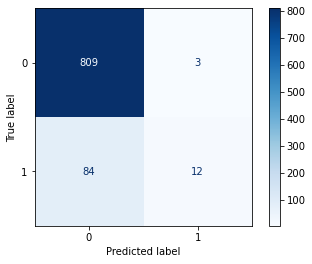

In [59]:
results(log,X_test_sc,y_test, X_train_sc, y_train)

In [60]:
pipe_knn = Pipeline([
    ('pc',PCA()),
    ('model',KNeighborsClassifier())
])

knn_params = {'pc__n_components':[10,15,20],
              'model__n_neighbors':[3,4,5,6],
             'model__p':[2,3,4]}

knn = GridSearchCV(pipe_knn,
                     knn_params,
                     cv=5,
                     verbose=1)

knn.fit(X_train_sc,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   32.1s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pc', PCA()),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': [3, 4, 5, 6],
                         'model__p': [2, 3, 4],
                         'pc__n_components': [10, 15, 20]},
             verbose=1)

Best Score(cross_val_score) is:  0.9026079330814895
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__n_neighbors': 4, 'model__p': 3, 'pc__n_components': 10}
----------------------------------------------------------------------
Train score is:  0.9173098125689085
Test score is:  0.8887665198237885
----------------------------------------------------------------------
Specificity:  0.979064039408867
Sensitivity:  0.125


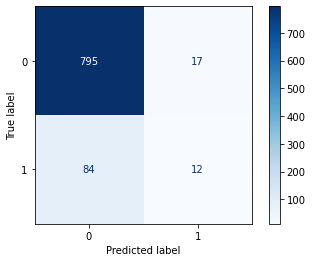

In [61]:
results(knn,X_test_sc,y_test, X_train_sc, y_train)

In [62]:
pipe_rfc = Pipeline([
    ('pc',PCA()),
    ('model',RandomForestClassifier())
])
rfc_params = {'pc__n_components':[10,15,20],
              'model__criterion':['gini','entropy'],
              'model__max_features':['auto','sqrt','log2'],
             'model__ccp_alpha':[0.01,0.05,0.07]}
# Support Vector Classifier was modelled in different Notebook due to significant runtimes.
rfc = GridSearchCV(pipe_rfc,
                     rfc_params,
                     cv=5,
                     verbose=1)
rfc.fit(X_train_sc,y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  5.9min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pc', PCA()),
                                       ('model', RandomForestClassifier())]),
             param_grid={'model__ccp_alpha': [0.01, 0.05, 0.07],
                         'model__criterion': ['gini', 'entropy'],
                         'model__max_features': ['auto', 'sqrt', 'log2'],
                         'pc__n_components': [10, 15, 20]},
             verbose=1)

Best Score(cross_val_score) is:  0.9059154074473825
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__ccp_alpha': 0.01, 'model__criterion': 'entropy', 'model__max_features': 'log2', 'pc__n_components': 20}
----------------------------------------------------------------------
Train score is:  0.9059169423006248
Test score is:  0.9052863436123348
----------------------------------------------------------------------
Specificity:  1.0
Sensitivity:  0.10416666666666667


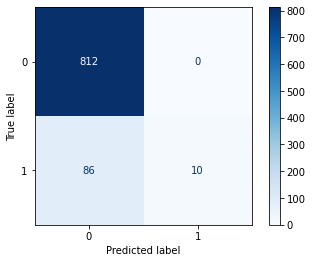

In [63]:
results(rfc,X_test_sc,y_test, X_train_sc, y_train)

### The RFC model performed the best here for accommodations, but only barely above the baseline

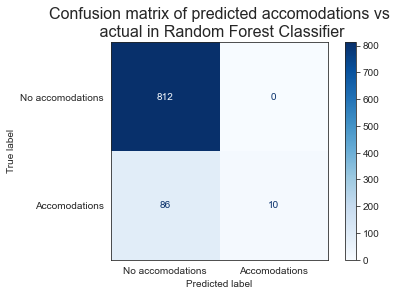

In [116]:
### BEST MODEL

cl.con_plot(rfc, X_test_sc,y_test, 'Random Forest Classifier')

In [65]:
pipe_ada = Pipeline([
    ('pc',PCA()),
    ('model',AdaBoostClassifier())
])
ada_params = {'pc__n_components':[10,15,20],
              'model__n_estimators':[40,50,60],
             'model__learning_rate':[0.5,1,1.5]}
ada = GridSearchCV(pipe_ada,
                     ada_params,
                     cv=5,
                     verbose=1)
ada.fit(X_train_sc,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  1.3min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pc', PCA()),
                                       ('model', AdaBoostClassifier())]),
             param_grid={'model__learning_rate': [0.5, 1, 1.5],
                         'model__n_estimators': [40, 50, 60],
                         'pc__n_components': [10, 15, 20]},
             verbose=1)

Best Score(cross_val_score) is:  0.9059154074473825
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__learning_rate': 1, 'model__n_estimators': 40, 'pc__n_components': 20}
----------------------------------------------------------------------
Train score is:  0.9066519661889011
Test score is:  0.9008810572687225
----------------------------------------------------------------------
Specificity:  0.9889162561576355
Sensitivity:  0.15625


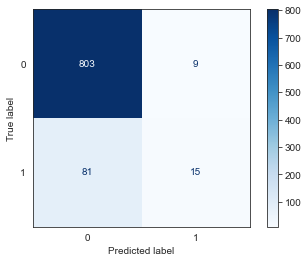

In [66]:
results(ada,X_test_sc,y_test, X_train_sc, y_train)

In [67]:
pipe_bag = Pipeline([
    ('pc',PCA()),
    ('model',BaggingClassifier())
])
bag_params = {'pc__n_components':[10,15,20],
              'model__n_estimators':[10,20,30],
              'model__max_samples':[1,2,3]
             }
bag = GridSearchCV(pipe_bag,
                     bag_params,
                     cv=5,
                     verbose=1)
bag.fit(X_train_sc,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:   18.6s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pc', PCA()),
                                       ('model', BaggingClassifier())]),
             param_grid={'model__max_samples': [1, 2, 3],
                         'model__n_estimators': [10, 20, 30],
                         'pc__n_components': [10, 15, 20]},
             verbose=1)

Best Score(cross_val_score) is:  0.8948920669185106
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__max_samples': 1, 'model__n_estimators': 10, 'pc__n_components': 10}
----------------------------------------------------------------------
Train score is:  0.8948915839764793
Test score is:  0.8942731277533039
----------------------------------------------------------------------
Specificity:  1.0
Sensitivity:  0.0


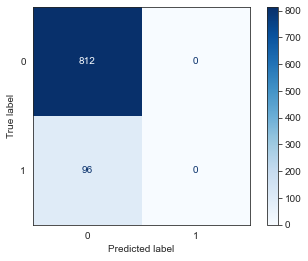

In [68]:
results(bag,X_test_sc,y_test, X_train_sc, y_train)

In [69]:
pipe_svc = Pipeline([
    ('pc',PCA()),
    ('model',SVC())
])
svc_params = {'pc__n_components':[10,15,20],
              'model__C':[0.01,0.05],
             'model__degree':[3,4,5]}
svc = GridSearchCV(pipe_svc,
                     svc_params,
                     cv=5,
                     verbose=1)
svc.fit(X_train_sc,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   12.9s finished


GridSearchCV(cv=5, estimator=Pipeline(steps=[('pc', PCA()), ('model', SVC())]),
             param_grid={'model__C': [0.01, 0.05], 'model__degree': [3, 4, 5],
                         'pc__n_components': [10, 15, 20]},
             verbose=1)

Best Score(cross_val_score) is:  0.8948920669185106
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__C': 0.01, 'model__degree': 3, 'pc__n_components': 10}
----------------------------------------------------------------------
Train score is:  0.8948915839764793
Test score is:  0.8942731277533039
----------------------------------------------------------------------
Specificity:  1.0
Sensitivity:  0.0


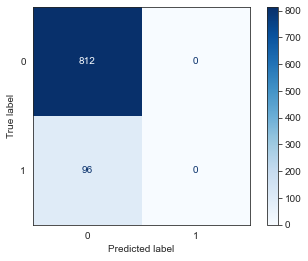

In [70]:
results(svc,X_test_sc,y_test, X_train_sc, y_train)

## Try pipelines without PCA and grid search (note scaling was done above)

In [71]:
pipe_log = Pipeline([
    ('model',LogisticRegression())
])

log_params = {'model__max_iter': [500, 1000],
              'model__C': [.1, 1, 10, 100],
              'model__solver': ['liblinear', 'lbfgs', 'sag'],
              'model__penalty': ['l2']}

log2 = GridSearchCV(pipe_log,
                     log_params,
                     cv=5,
                     verbose=1)

log2.fit(X_train_sc,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', LogisticRegression())]),
             param_grid={'model__C': [0.1, 1, 10, 100],
                         'model__max_iter': [500, 1000],
                         'model__penalty': ['l2'],
                         'model__solver': ['liblinear', 'lbfgs', 'sag']},
             verbose=1)

Best Score(cross_val_score) is:  0.9007710469508906
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__C': 0.1, 'model__max_iter': 500, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
----------------------------------------------------------------------
Train score is:  0.9055494303564866
Test score is:  0.9008810572687225
----------------------------------------------------------------------
Specificity:  0.9901477832512315
Sensitivity:  0.14583333333333334


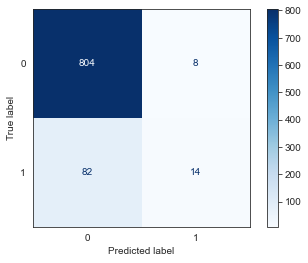

In [72]:
results(log2,X_test_sc,y_test, X_train_sc, y_train)

In [73]:
pipe_knn = Pipeline([
    ('model',KNeighborsClassifier())
])

knn_params = {'model__n_neighbors':[3,4,5,6],
             'model__p':[2,3,4]}

knn2 = GridSearchCV(pipe_knn,
                     knn_params,
                     cv=5,
                     verbose=1)

knn2.fit(X_train_sc,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.1min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': [3, 4, 5, 6],
                         'model__p': [2, 3, 4]},
             verbose=1)

Best Score(cross_val_score) is:  0.9004020507285482
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__n_neighbors': 6, 'model__p': 2}
----------------------------------------------------------------------
Train score is:  0.9081220139654539
Test score is:  0.9008810572687225
----------------------------------------------------------------------
Specificity:  0.9926108374384236
Sensitivity:  0.125


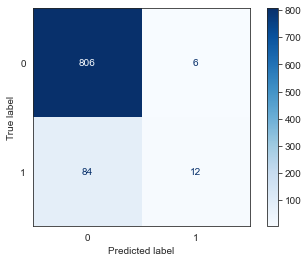

In [74]:
results(knn2,X_test_sc,y_test, X_train_sc, y_train)

In [75]:
pipe_rfc = Pipeline([
    ('model',RandomForestClassifier())
])
rfc_params = {'model__criterion':['gini','entropy'],
              'model__max_features':['auto','sqrt','log2'],
             'model__ccp_alpha':[0.01,0.05,0.07]}
# Support Vector Classifier was modelled in different Notebook due to significant runtimes.
rfc2 = GridSearchCV(pipe_rfc,
                     rfc_params,
                     cv=5,
                     verbose=1)
rfc2.fit(X_train_sc,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.1min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model', RandomForestClassifier())]),
             param_grid={'model__ccp_alpha': [0.01, 0.05, 0.07],
                         'model__criterion': ['gini', 'entropy'],
                         'model__max_features': ['auto', 'sqrt', 'log2']},
             verbose=1)

Best Score(cross_val_score) is:  0.8959950080949813
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__ccp_alpha': 0.01, 'model__criterion': 'entropy', 'model__max_features': 'auto'}
----------------------------------------------------------------------
Train score is:  0.8948915839764793
Test score is:  0.8942731277533039
----------------------------------------------------------------------
Specificity:  1.0
Sensitivity:  0.0


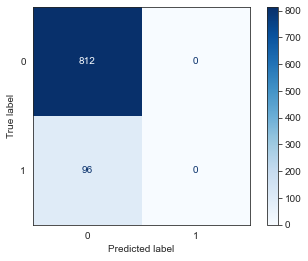

In [76]:
results(rfc2,X_test_sc,y_test, X_train_sc, y_train)

In [77]:
pipe_ada = Pipeline([
    ('pc',PCA()),
    ('model',AdaBoostClassifier())
])
ada_params = {'model__n_estimators':[40,50,60],
             'model__learning_rate':[0.5,1,1.5]}
ada2 = GridSearchCV(pipe_ada,
                     ada_params,
                     cv=5,
                     verbose=1)
ada2.fit(X_train_sc,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pc', PCA()),
                                       ('model', AdaBoostClassifier())]),
             param_grid={'model__learning_rate': [0.5, 1, 1.5],
                         'model__n_estimators': [40, 50, 60]},
             verbose=1)

Best Score(cross_val_score) is:  0.9026079330814895
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__learning_rate': 0.5, 'model__n_estimators': 40}
----------------------------------------------------------------------
Train score is:  0.9059169423006248
Test score is:  0.9030837004405287
----------------------------------------------------------------------
Specificity:  0.9938423645320197
Sensitivity:  0.13541666666666666


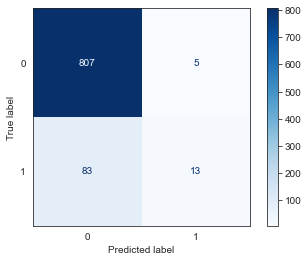

In [78]:
results(ada2,X_test_sc,y_test, X_train_sc, y_train)

In [79]:
pipe_bag = Pipeline([
    ('model',BaggingClassifier())
])
bag_params = {'model__n_estimators':[10,20,30],
              'model__max_samples':[1,2,3]
             }
bag2 = GridSearchCV(pipe_bag,
                     bag_params,
                     cv=5,
                     verbose=1)
bag2.fit(X_train_sc,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    5.7s finished


GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', BaggingClassifier())]),
             param_grid={'model__max_samples': [1, 2, 3],
                         'model__n_estimators': [10, 20, 30]},
             verbose=1)

Best Score(cross_val_score) is:  0.8948920669185106
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__max_samples': 1, 'model__n_estimators': 10}
----------------------------------------------------------------------
Train score is:  0.8948915839764793
Test score is:  0.8942731277533039
----------------------------------------------------------------------
Specificity:  1.0
Sensitivity:  0.0


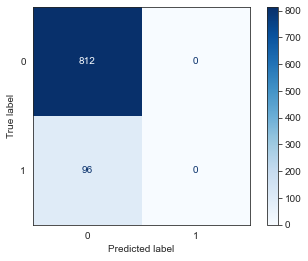

In [80]:
results(bag2,X_test_sc,y_test, X_train_sc, y_train)

In [81]:
pipe_bag = Pipeline([
    ('model',SVC())
])
svc_params = {'model__C':[0.01,0.05],
             'model__degree':[3,4,5]}
svc2 = GridSearchCV(pipe_bag,
                     svc_params,
                     cv=5,
                     verbose=1)
svc2.fit(X_train_sc,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   15.8s finished


GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', SVC())]),
             param_grid={'model__C': [0.01, 0.05], 'model__degree': [3, 4, 5]},
             verbose=1)

# Binary Modeling - target is whether state violence occured

In [82]:
columns_to_drop = list_of_responses + ['stateresponse','state_violence']
columns_of_interests = 'state_violence'

X_v = all_encoded.drop(columns = columns_to_drop)
y_v = all_encoded[columns_of_interests]


X_v.head()

,id,year,protest,protestnumber,startday,startmonth,startyear,endday,endmonth,endyear,protesterviolence,years,months,days,total_days,labor wage dispute,land farm issue,police brutality,"political behavior, process","price increases, tax policy",removal of politician,social restrictions,country_Benin,country_Botswana,country_Burkina Faso,country_Burundi,country_Cameroon,country_Cape Verde,country_Central African Republic,country_Chad,country_Comoros,country_Congo Brazzaville,country_Congo Kinshasa,country_Djibouti,country_Equatorial Guinea,country_Eritrea,country_Ethiopia,country_Gabon,country_Gambia,country_Ghana,country_Guinea,country_Guinea-Bissau,country_Ivory Coast,country_Kenya,country_Lesotho,country_Liberia,country_Madagascar,country_Malawi,country_Mali,country_Mauritania,country_Mauritius,country_Mozambique,country_Namibia,country_Niger,country_Nigeria,country_Rwanda,country_Senegal,country_Sierra Leone,country_Somalia,country_South Africa,country_South Sudan,country_Swaziland,country_Tanzania,country_Togo,country_Uganda,country_Zambia,country_Zimbabwe,participants_category_1000-1999,participants_category_2000-4999,participants_category_50-99,participants_category_5000-10000,participants_category_999,participants_category_>10000,protesterdemand_1.0,protesterdemand_10.0,protesterdemand_11.0,protesterdemand_100.0,protesterdemand_101.0,protesterdemand_110.0,protesterdemand_111.0,protesterdemand_1000.0,protesterdemand_1001.0,protesterdemand_1010.0,protesterdemand_1011.0,protesterdemand_1100.0,protesterdemand_1101.0,protesterdemand_2000.0,protesterdemand_10000.0,protesterdemand_10001.0,protesterdemand_10010.0,protesterdemand_10100.0,protesterdemand_11000.0,protesterdemand_11001.0,protesterdemand_100000.0,protesterdemand_100001.0,protesterdemand_100010.0,protesterdemand_100100.0,protesterdemand_100101.0,protesterdemand_101000.0,protesterdemand_101001.0,protesterdemand_110000.0,protesterdemand_110001.0,protesterdemand_110011.0,protesterdemand_111000.0,protesterdemand_1000000.0,protesterdemand_1000001.0,protesterdemand_1000011.0,protesterdemand_1000100.0,protesterdemand_1001001.0,protesterdemand_1010000.0,protesterdemand_1010001.0,protesterdemand_1100000.0,protesterdemand_1100001.0,protesterdemand_1100011.0
7974,4021990000,1990,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7975,4021991000,1991,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7976,4021992000,1992,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7977,4021993000,1993,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7978,4021994000,1994,0,0,999.0,999.0,999.0,999.0,999.0,999.0,999.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [83]:
y_v.head()

7974    0.0
7975    0.0
7976    0.0
7977    0.0
7978    0.0
Name: state_violence, dtype: float64

In [84]:
# Train Test Split
X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(X_v, y_v, stratify = y_v, random_state = 42)

## Baseline Score

In [85]:
y_v.value_counts()

0.0    3239
1.0     390
Name: state_violence, dtype: int64

In [86]:
y_v.value_counts(normalize=True)

0.0    0.892532
1.0    0.107468
Name: state_violence, dtype: float64

In [87]:
y_train_v.value_counts(normalize=True)

0.0    0.892687
1.0    0.107313
Name: state_violence, dtype: float64

In [88]:
y_test_v.value_counts(normalize=True)

0.0    0.89207
1.0    0.10793
Name: state_violence, dtype: float64

## Scale data

In [89]:
ss = StandardScaler()

X_train_sc_v = ss.fit_transform(X_train_v)
X_test_sc_v = ss.transform(X_test_v)

## Out-of-the-box-models on the data

In [90]:
log = LogisticRegression()
knn_c = KNeighborsClassifier()
dec_c = DecisionTreeClassifier()
bag_c = BaggingClassifier()
ran_c = RandomForestClassifier()
ada_c = AdaBoostClassifier()
svc = SVC()

models_c = [log, knn_c, dec_c, bag_c, ran_c, ada_c, svc]

def eval_models(list_of_models, X_train_sc,y_train, X_test_sc, y_test):
    for model in models_c:
        model.fit(X_train_sc, y_train)

        # Review Accuracy
        train_acc_score = model.score(X_train_sc, y_train)
        test_acc_score = model.score(X_test_sc, y_test)    
        print(f'For model {model}:')
        print(f'     Train Acc score: {train_acc_score.round(4)}\n     Test Acc score: {test_acc_score.round(4)}')


        # Create prediction to get f1_score
        train_pred = model.predict(X_train_sc)
        test_pred = model.predict(X_test_sc)

        train_f1 =f1_score(y_train, train_pred, average='binary')
        test_f1 = f1_score(y_test, test_pred, average='binary')

        print(f'     Train f1 score: {train_f1.round(3)}\n     Test f1 score: {test_f1.round(3)}\n\n')

In [91]:
eval_models(models_c, X_train_sc_v,y_train_v, X_test_sc_v, y_test_v)

For model LogisticRegression():
     Train Acc score: 0.8964
     Test Acc score: 0.8899
     Train f1 score: 0.09
     Test f1 score: 0.0


For model KNeighborsClassifier():
     Train Acc score: 0.9033
     Test Acc score: 0.8789
     Train f1 score: 0.302
     Test f1 score: 0.141


For model DecisionTreeClassifier():
     Train Acc score: 1.0
     Test Acc score: 0.8359
     Train f1 score: 1.0
     Test f1 score: 0.236


For model BaggingClassifier():
     Train Acc score: 0.989
     Test Acc score: 0.8844
     Train f1 score: 0.946
     Test f1 score: 0.173


For model RandomForestClassifier():
     Train Acc score: 1.0
     Test Acc score: 0.8877
     Train f1 score: 1.0
     Test f1 score: 0.019


For model AdaBoostClassifier():
     Train Acc score: 0.8971
     Test Acc score: 0.8877
     Train f1 score: 0.239
     Test f1 score: 0.164


For model SVC():
     Train Acc score: 0.896
     Test Acc score: 0.8921
     Train f1 score: 0.06
     Test f1 score: 0.02




## Try pipelines without PCA and grid search (note scaling was done above)

In [92]:
pipe_log = Pipeline([
    ('model',LogisticRegression())
])

log_params = {'model__max_iter': [500, 1000],
              'model__C': [.1, 1, 10, 100],
              'model__solver': ['liblinear', 'lbfgs', 'sag'],
              'model__penalty': ['l2']}

log_v = GridSearchCV(pipe_log,
                     log_params,
                     cv=5,
                     verbose=1)

log_v.fit(X_train_sc_v,y_train_v)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/jenniferwilliamson/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  2.0min finished


GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', LogisticRegression())]),
             param_grid={'model__C': [0.1, 1, 10, 100],
                         'model__max_iter': [500, 1000],
                         'model__penalty': ['l2'],
                         'model__solver': ['liblinear', 'lbfgs', 'sag']},
             verbose=1)

Best Score(cross_val_score) is:  0.8904816513761468
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__C': 0.1, 'model__max_iter': 500, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
----------------------------------------------------------------------
Train score is:  0.8956266078647556
Test score is:  0.8898678414096917
----------------------------------------------------------------------
Specificity:  0.9975308641975309
Sensitivity:  0.0


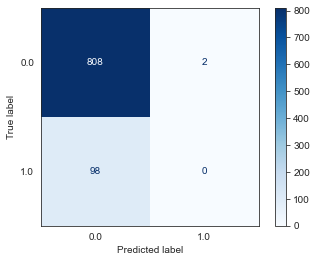

In [93]:
results(log_v,X_test_sc_v,y_test_v, X_train_sc_v, y_train_v)

In [94]:
pipe_knn = Pipeline([
    ('model',KNeighborsClassifier())
])

knn_params = {'model__n_neighbors':[3,4,5,6],
             'model__p':[2,3,4]}

knn_v = GridSearchCV(pipe_knn,
                     knn_params,
                     cv=5,
                     verbose=1)

knn_v.fit(X_train_sc_v,y_train_v)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.1min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': [3, 4, 5, 6],
                         'model__p': [2, 3, 4]},
             verbose=1)

Best Score(cross_val_score) is:  0.8886427415002698
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__n_neighbors': 6, 'model__p': 4}
----------------------------------------------------------------------
Train score is:  0.900404263138552
Test score is:  0.8876651982378855
----------------------------------------------------------------------
Specificity:  0.991358024691358
Sensitivity:  0.030612244897959183


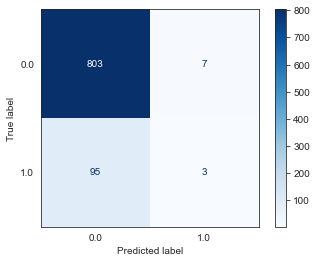

In [95]:
results(knn_v,X_test_sc_v,y_test_v, X_train_sc_v, y_train_v)

In [96]:
pipe_rfc = Pipeline([
    ('model',RandomForestClassifier())
])
rfc_params = {'model__criterion':['gini','entropy'],
              'model__max_features':['auto','sqrt','log2'],
             'model__ccp_alpha':[0.01,0.05,0.07]}
# Support Vector Classifier was modelled in different Notebook due to significant runtimes.
rfc_v = GridSearchCV(pipe_rfc,
                     rfc_params,
                     cv=5,
                     verbose=1)
rfc_v.fit(X_train_sc_v,y_train_v)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   60.0s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model', RandomForestClassifier())]),
             param_grid={'model__ccp_alpha': [0.01, 0.05, 0.07],
                         'model__criterion': ['gini', 'entropy'],
                         'model__max_features': ['auto', 'sqrt', 'log2']},
             verbose=1)

Best Score(cross_val_score) is:  0.8926868591473287
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__ccp_alpha': 0.01, 'model__criterion': 'gini', 'model__max_features': 'auto'}
----------------------------------------------------------------------
Train score is:  0.8926865123116501
Test score is:  0.8920704845814978
----------------------------------------------------------------------
Specificity:  1.0
Sensitivity:  0.0


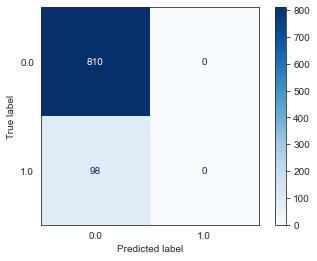

In [97]:
results(rfc_v,X_test_sc_v,y_test_v, X_train_sc_v, y_train_v)

In [98]:
pipe_ada = Pipeline([
    ('pc',PCA()),
    ('model',AdaBoostClassifier())
])
ada_params = {'model__n_estimators':[40,50,60],
             'model__learning_rate':[0.5,1,1.5]}
ada_v = GridSearchCV(pipe_ada,
                     ada_params,
                     cv=5,
                     verbose=1)
ada_v.fit(X_train_sc_v,y_train_v)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  2.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pc', PCA()),
                                       ('model', AdaBoostClassifier())]),
             param_grid={'model__learning_rate': [0.5, 1, 1.5],
                         'model__n_estimators': [40, 50, 60]},
             verbose=1)

Best Score(cross_val_score) is:  0.8897463572584998
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__learning_rate': 0.5, 'model__n_estimators': 60}
----------------------------------------------------------------------
Train score is:  0.8978316795295848
Test score is:  0.8854625550660793
----------------------------------------------------------------------
Specificity:  0.9901234567901235
Sensitivity:  0.02040816326530612


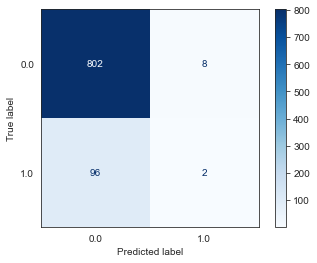

In [99]:
results(ada_v,X_test_sc_v,y_test_v, X_train_sc_v, y_train_v)

In [100]:
pipe_bag = Pipeline([
    ('model',BaggingClassifier())
])
bag_params = {'model__n_estimators':[10,20,30],
              'model__max_samples':[1,2,3]
             }
bag_v = GridSearchCV(pipe_bag,
                     bag_params,
                     cv=5,
                     verbose=1)
bag_v.fit(X_train_sc_v,y_train_v)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    5.6s finished


GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', BaggingClassifier())]),
             param_grid={'model__max_samples': [1, 2, 3],
                         'model__n_estimators': [10, 20, 30]},
             verbose=1)

Best Score(cross_val_score) is:  0.8926868591473287
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__max_samples': 1, 'model__n_estimators': 10}
----------------------------------------------------------------------
Train score is:  0.8926865123116501
Test score is:  0.8920704845814978
----------------------------------------------------------------------
Specificity:  1.0
Sensitivity:  0.0


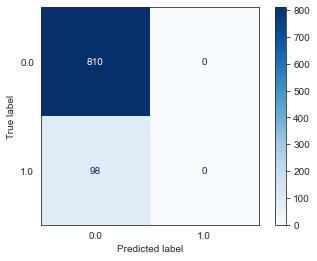

In [101]:
results(bag_v,X_test_sc_v,y_test_v, X_train_sc_v, y_train_v)

In [102]:
pipe_bag = Pipeline([
    ('model',SVC())
])
svc_params = {'model__C':[0.01,0.05],
             'model__degree':[3,4,5]}
svc_v = GridSearchCV(pipe_bag,
                     svc_params,
                     cv=5,
                     verbose=1)
svc_v.fit(X_train_sc_v,y_train_v)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   16.0s finished


GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', SVC())]),
             param_grid={'model__C': [0.01, 0.05], 'model__degree': [3, 4, 5]},
             verbose=1)

Best Score(cross_val_score) is:  0.8926868591473287
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__C': 0.01, 'model__degree': 3}
----------------------------------------------------------------------
Train score is:  0.8926865123116501
Test score is:  0.8920704845814978
----------------------------------------------------------------------
Specificity:  1.0
Sensitivity:  0.0


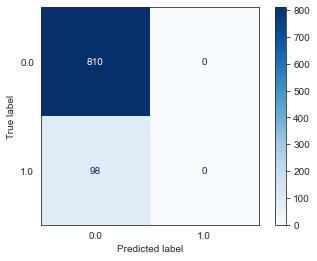

In [103]:
results(svc_v,X_test_sc_v,y_test_v, X_train_sc_v, y_train_v)

## Try pipelines with PCA and grid search (note scaling was done above)

In [104]:
pipe_log = Pipeline([
    ('pc',PCA()),
    ('model',LogisticRegression())
])

log_params = {'pc__n_components':[10,15,20],
              'model__max_iter': [500, 1000],
              'model__C': [.1, 1, 10, 100],
              'model__solver': ['liblinear', 'lbfgs', 'sag'],
              'model__penalty': ['l2']}

log_v2 = GridSearchCV(pipe_log,
                     log_params,
                     cv=5,
                     verbose=1)

log_v2.fit(X_train_sc_v,y_train_v)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:   32.9s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pc', PCA()),
                                       ('model', LogisticRegression())]),
             param_grid={'model__C': [0.1, 1, 10, 100],
                         'model__max_iter': [500, 1000],
                         'model__penalty': ['l2'],
                         'model__solver': ['liblinear', 'lbfgs', 'sag'],
                         'pc__n_components': [10, 15, 20]},
             verbose=1)

Best Score(cross_val_score) is:  0.8926868591473287
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__C': 0.1, 'model__max_iter': 500, 'model__penalty': 'l2', 'model__solver': 'liblinear', 'pc__n_components': 10}
----------------------------------------------------------------------
Train score is:  0.8926865123116501
Test score is:  0.8920704845814978
----------------------------------------------------------------------
Specificity:  1.0
Sensitivity:  0.0


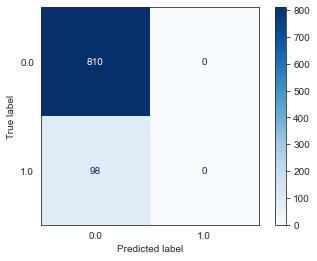

In [105]:
results(log_v2,X_test_sc_v,y_test_v, X_train_sc_v, y_train_v)

In [106]:
pipe_knn = Pipeline([
    ('pc',PCA()),
    ('model',KNeighborsClassifier())
])

knn_params = {'pc__n_components':[10,15,20],
              'model__n_neighbors':[3,4,5,6],
             'model__p':[2,3,4]}

knn_v2 = GridSearchCV(pipe_knn,
                     knn_params,
                     cv=5,
                     verbose=1)

knn_v2.fit(X_train_sc_v,y_train_v)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   41.8s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pc', PCA()),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': [3, 4, 5, 6],
                         'model__p': [2, 3, 4],
                         'pc__n_components': [10, 15, 20]},
             verbose=1)

Best Score(cross_val_score) is:  0.8897470318402589
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__n_neighbors': 6, 'model__p': 4, 'pc__n_components': 20}
----------------------------------------------------------------------
Train score is:  0.8981991914737228
Test score is:  0.8887665198237885
----------------------------------------------------------------------
Specificity:  0.9950617283950617
Sensitivity:  0.01020408163265306


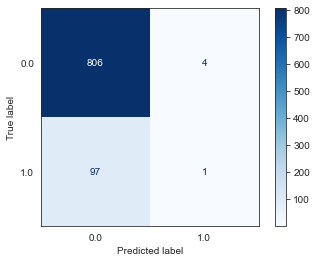

In [107]:
results(knn_v2,X_test_sc_v,y_test_v, X_train_sc_v, y_train_v)

In [108]:
pipe_rfc = Pipeline([
    ('pc',PCA()),
    ('model',RandomForestClassifier())
])
rfc_params = {'pc__n_components':[10,15,20],
              'model__criterion':['gini','entropy'],
              'model__max_features':['auto','sqrt','log2'],
             'model__ccp_alpha':[0.01,0.05,0.07]}
# Support Vector Classifier was modelled in different Notebook due to significant runtimes.
rfc_v2 = GridSearchCV(pipe_rfc,
                     rfc_params,
                     cv=5,
                     verbose=1)
rfc_v2.fit(X_train_sc_v,y_train_v)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  6.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pc', PCA()),
                                       ('model', RandomForestClassifier())]),
             param_grid={'model__ccp_alpha': [0.01, 0.05, 0.07],
                         'model__criterion': ['gini', 'entropy'],
                         'model__max_features': ['auto', 'sqrt', 'log2'],
                         'pc__n_components': [10, 15, 20]},
             verbose=1)

Best Score(cross_val_score) is:  0.8926868591473287
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__ccp_alpha': 0.01, 'model__criterion': 'gini', 'model__max_features': 'auto', 'pc__n_components': 10}
----------------------------------------------------------------------
Train score is:  0.8926865123116501
Test score is:  0.8920704845814978
----------------------------------------------------------------------
Specificity:  1.0
Sensitivity:  0.0


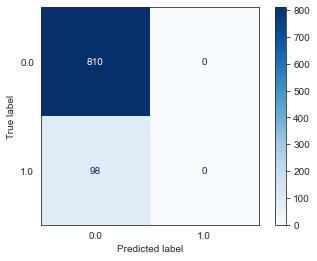

In [109]:
results(rfc_v2,X_test_sc_v,y_test_v, X_train_sc_v, y_train_v)

In [110]:
pipe_ada = Pipeline([
    ('pc',PCA()),
    ('model',AdaBoostClassifier())
])
ada_params = {'pc__n_components':[10,15,20],
              'model__n_estimators':[40,50,60],
             'model__learning_rate':[0.5,1,1.5]}
ada_v2 = GridSearchCV(pipe_ada,
                     ada_params,
                     cv=5,
                     verbose=1)
ada_v2.fit(X_train_sc_v,y_train_v)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  1.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pc', PCA()),
                                       ('model', AdaBoostClassifier())]),
             param_grid={'model__learning_rate': [0.5, 1, 1.5],
                         'model__n_estimators': [40, 50, 60],
                         'pc__n_components': [10, 15, 20]},
             verbose=1)

Best Score(cross_val_score) is:  0.8926868591473287
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__learning_rate': 0.5, 'model__n_estimators': 50, 'pc__n_components': 10}
----------------------------------------------------------------------
Train score is:  0.8941565600882029
Test score is:  0.8876651982378855
----------------------------------------------------------------------
Specificity:  0.9950617283950617
Sensitivity:  0.0


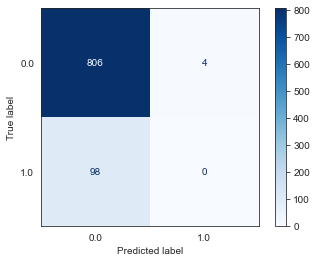

In [111]:
results(ada_v2,X_test_sc_v,y_test_v, X_train_sc_v, y_train_v)

### The AdaBoost model performed the best here for state violence, but only barely above the baseline.

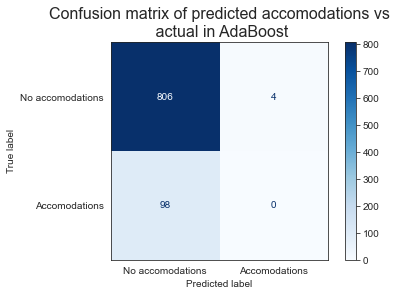

In [117]:
### BEST MODEL

cl.con_plot(ada_v2,X_test_sc_v,y_test_v, 'AdaBoost')

In [112]:
pipe_bag = Pipeline([
    ('pc',PCA()),
    ('model',BaggingClassifier())
])
bag_params = {'pc__n_components':[10,15,20],
              'model__n_estimators':[10,20,30],
              'model__max_samples':[1,2,3]
             }
bag_v2 = GridSearchCV(pipe_bag,
                     bag_params,
                     cv=5,
                     verbose=1)
bag_v2.fit(X_train_sc_v,y_train_v)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:   15.2s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pc', PCA()),
                                       ('model', BaggingClassifier())]),
             param_grid={'model__max_samples': [1, 2, 3],
                         'model__n_estimators': [10, 20, 30],
                         'pc__n_components': [10, 15, 20]},
             verbose=1)

Best Score(cross_val_score) is:  0.8926868591473287
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__max_samples': 1, 'model__n_estimators': 10, 'pc__n_components': 10}
----------------------------------------------------------------------
Train score is:  0.8926865123116501
Test score is:  0.8920704845814978
----------------------------------------------------------------------
Specificity:  1.0
Sensitivity:  0.0


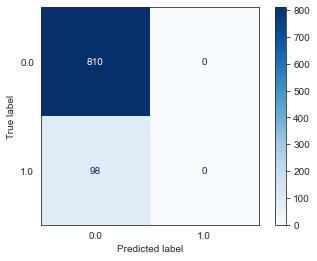

In [113]:
results(bag_v2,X_test_sc_v,y_test_v, X_train_sc_v, y_train_v)

In [114]:
pipe_svc = Pipeline([
    ('pc',PCA()),
    ('model',SVC())
])
svc_params = {'pc__n_components':[10,15,20],
              'model__C':[0.01,0.05],
             'model__degree':[3,4,5]}
svc_v2 = GridSearchCV(pipe_svc,
                     svc_params,
                     cv=5,
                     verbose=1)
svc_v2.fit(X_train_sc_v,y_train_v)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   12.5s finished


GridSearchCV(cv=5, estimator=Pipeline(steps=[('pc', PCA()), ('model', SVC())]),
             param_grid={'model__C': [0.01, 0.05], 'model__degree': [3, 4, 5],
                         'pc__n_components': [10, 15, 20]},
             verbose=1)

Best Score(cross_val_score) is:  0.8926868591473287
----------------------------------------------------------------------
Best parameters for the best score(cross_val_score) are:  {'model__C': 0.01, 'model__degree': 3, 'pc__n_components': 10}
----------------------------------------------------------------------
Train score is:  0.8926865123116501
Test score is:  0.8920704845814978
----------------------------------------------------------------------
Specificity:  1.0
Sensitivity:  0.0


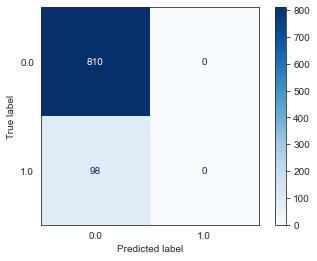

In [115]:
results(svc_v2,X_test_sc_v,y_test_v, X_train_sc_v, y_train_v)